Assignment in Data Analytics

by: Myk Erolf D. Roble,<br>   <t>
    Shion Suzuki

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/myk/Documents/programs/data analytics/Assignment_1_Data_Analytics/venv/lib/python3.11/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/jr/ht0rtnl55hq80pk016rxvhzw0000gn/T/b34a0087264946ed8bb8e8875ea89dc7-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/jr/ht0rtnl55hq80pk016rxvhzw0000gn/T/b34a0087264946ed8bb8e8875ea89dc7-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 205 COLUMNS
At line 33383 RHS
At line 33584 BOUNDS
At line 40221 ENDATA
Problem MODEL has 200 rows, 6636 columns and 13272 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.01 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.03   (Wallclock seconds):       0.04

Pain (3m): p-value = 0.0058
Urgency (3m): p-value = 0.6193
Frequency (3m): p-value

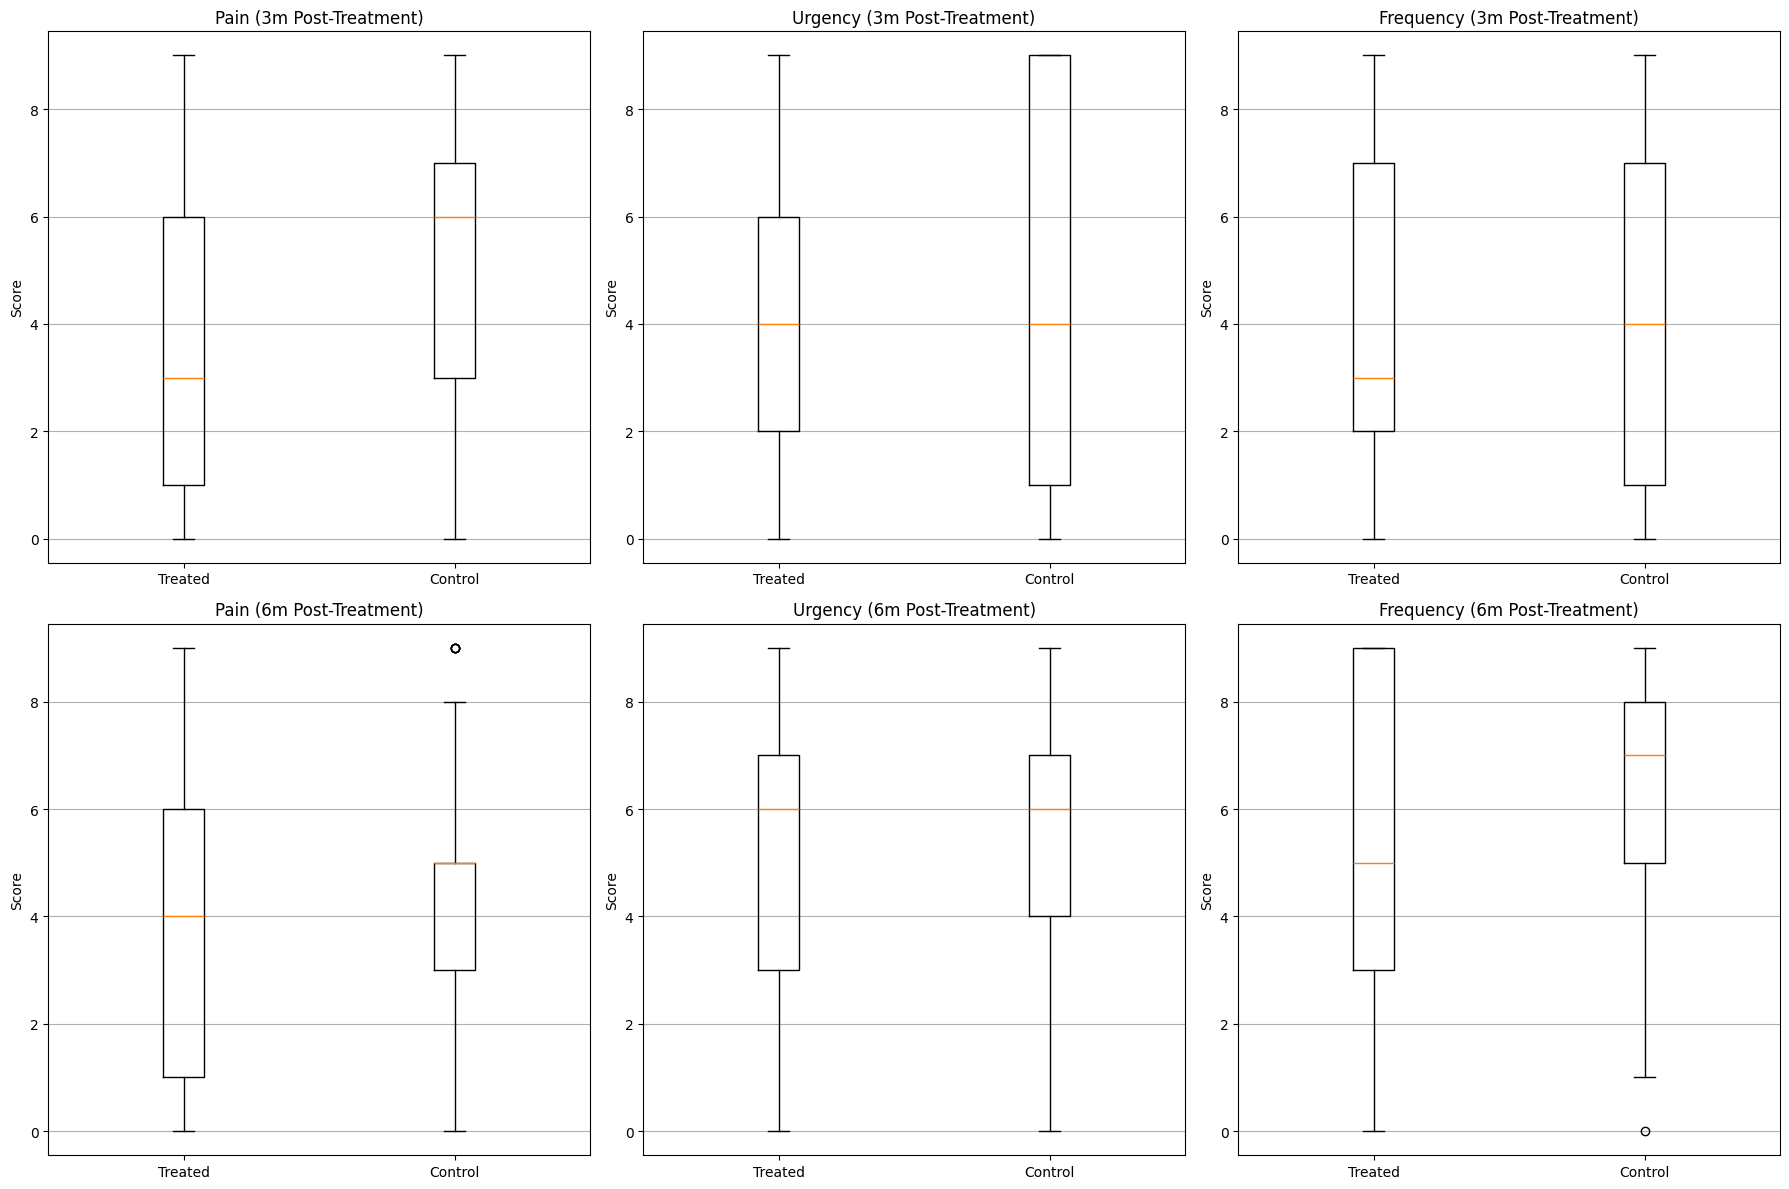

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial import distance
from scipy.stats import wilcoxon
from scipy.linalg import inv
import pulp

# Step 1: Simulate Data
np.random.seed(42)  # For reproducibility
num_patients = 200

# Create a DataFrame with patient data
dataset = pd.DataFrame({
    'patient_id': np.arange(1, num_patients + 1),
    'pain_baseline': np.random.randint(0, 10, num_patients),
    'urgency_baseline': np.random.randint(0, 10, num_patients),
    'frequency_baseline': np.random.randint(0, 10, num_patients),
    'treatment_time': np.random.choice([3, 6, np.nan], num_patients, p=[0.4, 0.4, 0.2]),
    'pain_3m': np.random.randint(0, 10, num_patients),
    'urgency_3m': np.random.randint(0, 10, num_patients),
    'frequency_3m': np.random.randint(0, 10, num_patients),
    'pain_6m': np.random.randint(0, 10, num_patients),
    'urgency_6m': np.random.randint(0, 10, num_patients),
    'frequency_6m': np.random.randint(0, 10, num_patients)
})

dataset['treated'] = dataset['treatment_time'].notna().astype(int)

# Step 2: Mahalanobis Distance Calculation
baseline_features = ['pain_baseline', 'urgency_baseline', 'frequency_baseline']
cov_inv = inv(dataset[baseline_features].cov())

def compute_mahalanobis(vec1, vec2):
    delta = vec1 - vec2
    return np.sqrt(delta.T @ cov_inv @ delta)

# Step 3: Optimal Matching
problem = pulp.LpProblem("Patient_Matching", pulp.LpMinimize)

potential_pairs = [(t_idx, c_idx) for t_idx in dataset.index for c_idx in dataset.index
                   if t_idx != c_idx and dataset.loc[t_idx, 'treated'] and not dataset.loc[c_idx, 'treated']]

match_decision = {pair: pulp.LpVariable(f"match_{pair[0]}_{pair[1]}", cat='Binary') for pair in potential_pairs}

pair_distances = {pair: compute_mahalanobis(dataset.loc[pair[0], baseline_features],
                                            dataset.loc[pair[1], baseline_features])
                  for pair in potential_pairs}

problem += pulp.lpSum(match_decision[pair] * pair_distances[pair] for pair in potential_pairs)

for idx in dataset.index:
    if dataset.loc[idx, 'treated']:
        problem += pulp.lpSum(match_decision[pair] for pair in potential_pairs if pair[0] == idx) == 1
    else:
        problem += pulp.lpSum(match_decision[pair] for pair in potential_pairs if pair[1] == idx) <= 1

problem.solve()

# Step 4: Matched Pairs Extraction
final_matches = [(t, c) for (t, c) in potential_pairs if pulp.value(match_decision[(t, c)]) == 1]

matched_results = pd.DataFrame([
    (dataset.loc[t, 'pain_3m'], dataset.loc[c, 'pain_3m'],
     dataset.loc[t, 'urgency_3m'], dataset.loc[c, 'urgency_3m'],
     dataset.loc[t, 'frequency_3m'], dataset.loc[c, 'frequency_3m'],
     dataset.loc[t, 'pain_6m'], dataset.loc[c, 'pain_6m'],
     dataset.loc[t, 'urgency_6m'], dataset.loc[c, 'urgency_6m'],
     dataset.loc[t, 'frequency_6m'], dataset.loc[c, 'frequency_6m'])
    for t, c in final_matches
], columns=['pain_treated_3m', 'pain_control_3m', 'urgency_treated_3m', 'urgency_control_3m',
            'frequency_treated_3m', 'frequency_control_3m',
            'pain_treated_6m', 'pain_control_6m', 'urgency_treated_6m', 'urgency_control_6m',
            'frequency_treated_6m', 'frequency_control_6m'])

# Step 5: Wilcoxon Signed-Rank Test
wilcoxon_results = {}
for time in ['3m', '6m']:
    for symptom in ['pain', 'urgency', 'frequency']:
        stat, pval = wilcoxon(matched_results[f'{symptom}_treated_{time}'], matched_results[f'{symptom}_control_{time}'])
        wilcoxon_results[f'{symptom}_{time}'] = pval
        print(f"{symptom.capitalize()} ({time}): p-value = {pval:.4f}")

# Step 6: Visualization
fig, axs = plt.subplots(2, 3, figsize=(18, 12))

times = ['3m', '6m']
for i, time in enumerate(times):
    for j, symptom in enumerate(['pain', 'urgency', 'frequency']):
        axs[i, j].boxplot([matched_results[f'{symptom}_treated_{time}'], matched_results[f'{symptom}_control_{time}']],
                           tick_labels=['Treated', 'Control'])
        axs[i, j].set_title(f'{symptom.capitalize()} ({time} Post-Treatment)')
        axs[i, j].set_ylabel('Score')
        axs[i, j].grid(axis='y')

plt.tight_layout()
plt.show()
